# Time Series Analysis
## Recovering A Stochastic Signal 

* By Daniel Cuneo

This is a pretty basic example of how to filter and recover a random signal from a time series that is a combination of confounding noise.

In [72]:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
%watermark -p numpy,scipy,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark

numpy 1.10.1
scipy 0.16.0
pandas 0.16.2
matplotlib 1.4.0


In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
%matplotlib inline

In [74]:
df = pd.read_csv("/home/daniel/OrbitalInsights/data.csv")

In [75]:
df.head()

,date,day.of.week,car.count,weather
0,2010-01-01,friday,94.5,-0.1
1,2010-01-02,saturday,108.4,-2.4
2,2010-01-03,sunday,105.5,-0.5
3,2010-01-04,monday,109.6,-2.1
4,2010-01-05,tuesday,116.1,1.9


In [76]:
# like using Pandas b/c of the datetime features, resample or groupby
# but I haven't used date methods in a while and lost some time to redresh my memory
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)

## Initial Plot

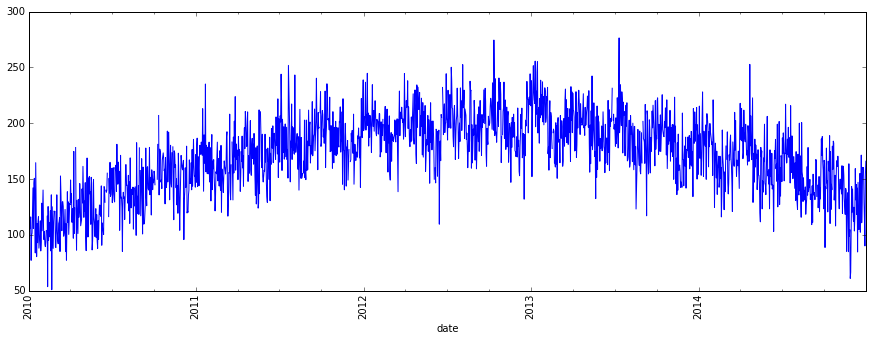

In [77]:
df['car.count'].plot(rot=90, figsize=(15,5));

I'd guess that we have a linear combination of a quadratic, sinusoid and random stochastic signal.


### Single Year Analysis: first year in the record

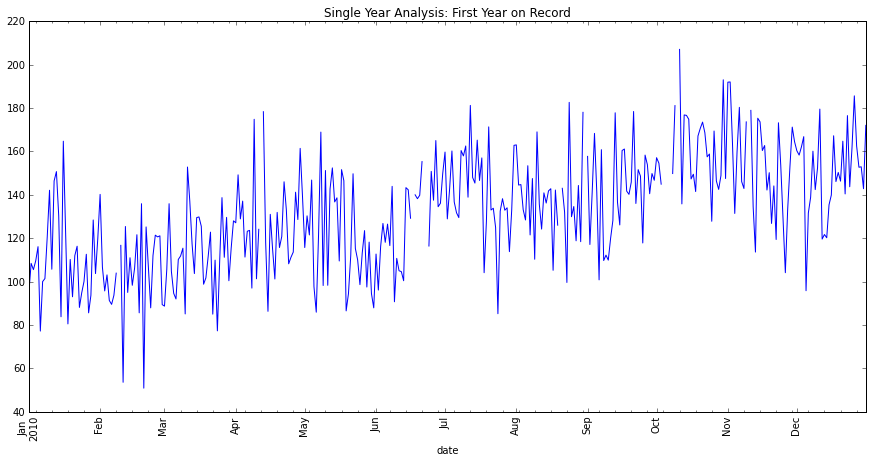

In [110]:
# year = df['car.count'][0:365]  if you are in a rush
year = df[df['date'] < pd.to_datetime('20110101')]['car.count']
year.plot(rot=90, figsize=(15,7), title="Single Year Analysis: First Year on Record");

It's not easy to see, but there are missing values in the series. We need to treat those.

In [79]:
#TODO: add to signal processing module

def remove_nans(data, return_nan_index=False):
    nan_ind = np.nonzero(~np.isfinite(data))[0]
    good_data_ind = np.nonzero(np.isfinite(data))[0]
    good_data = data[good_data_ind]
          
    new_points = np.interp(nan_ind, good_data_ind, good_data)
    data[nan_ind] = new_points
    
    if return_nan_index:
        return data, nan_ind
    else:
        return data

In [80]:
year, nan_ind = remove_nans(year.copy(), return_nan_index=True)
year_linear_det = signal.detrend(year, axis=0, type='linear')

Single Year Linear Detrend Time Series

(0, 366)

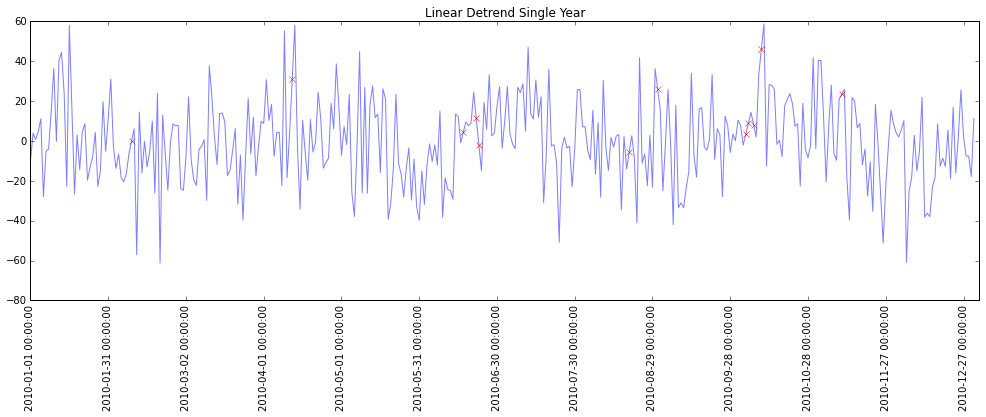

In [81]:
plt.figure(figsize=(17, 5))
plt.xticks(np.arange(year.shape[0])[0::30], year.index[0::30], rotation=90)
plt.plot(year_linear_det, alpha=0.5)
plt.title("Linear Detrend Single Year")
plt.plot(nan_ind, year_linear_det[nan_ind], 'rx')
plt.xlim(0, 366)

We see a $\approx$ 90 day period here.

Without more insight about the data we don't know if this is a nuisance or
a feature we are looking for.

The NaN replacements look reasonable.

## Group By for  Basic Analysis
Grouping the data points into bins and taking the mean, is very simialr to a Fourier Transform.

Pandas makes this easy and there's no reason not to. Especially if the data is related to business trends.

### Group by Month: Global monthly trend averaging over the 5 samples of each month

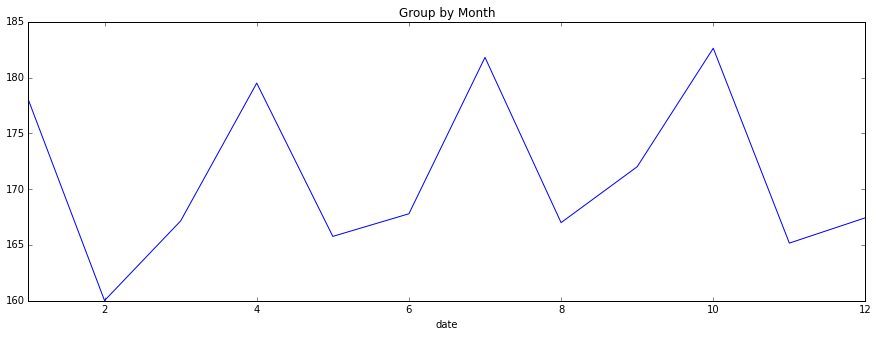

In [82]:
grp = df.groupby(df.date.map(lambda x:x.month))
grp.mean()['car.count'].plot(figsize=(15,5), title="Group by Month");

A group-by is sort of like a Fourier Transform where we choose just one frequency bin. There's the sinusodial period $\approx$ 90 days.

### Group by Day: Global day trend averaging over the 5 samples of each day

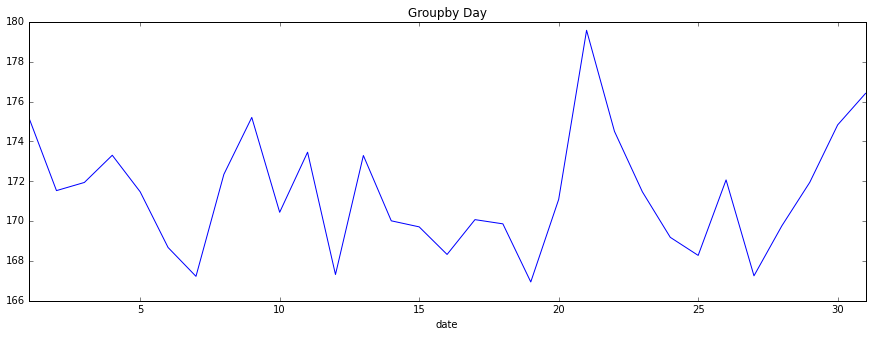

In [83]:
grp = df.groupby(df.date.map(lambda x:x.day))
grp.mean()['car.count'].plot(figsize=(15,5), title="Groupby Day");

It would appear as though the 21st day of each month saw greater count. 

## Removing Confounds
### Quadratic Detrend Using PolyFit

In [96]:
poly =  np.polynomial.polynomial             

t = np.arange(df.shape[0])
coefs, stats = poly.polyfit(t, counts, deg=2, full=True)
fit_curve = poly.polyval(t, coefs)

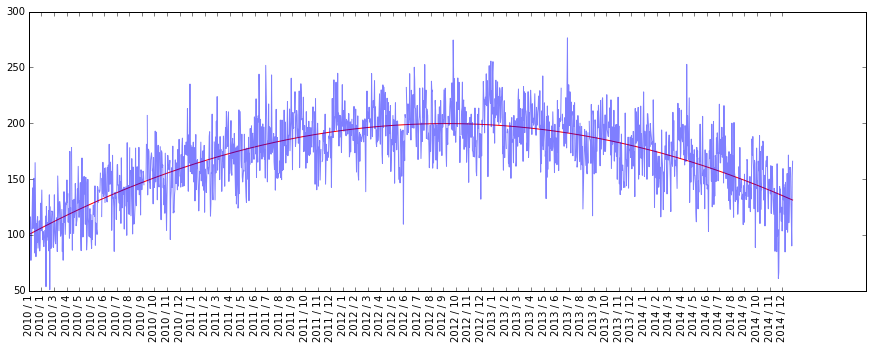

In [98]:
plt.figure(figsize=(15,5))

plt.plot(fit_curve, 'r')
plt.plot(t, df['car.count'], alpha=0.5)

labels = df['date']
date_str = map(lambda x: str(x.year) + " / "  + str(x.month), labels)
plt.xticks(t[0::30], date_str[0::30], rotation="vertical");

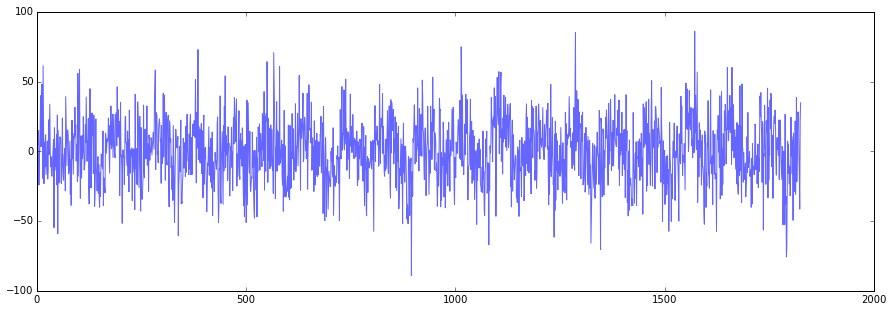

In [99]:
det_curve = counts - fit_curve
plt.figure(figsize=(15,5))
plt.plot(det_curve, alpha=0.6);

## Further Confound Removal
Lets suppose that the quadratic is a measurement error and that the $\approx$ 90 day sinusodial is a well understood or nuisance, then we'll examine the remainder of the signal.

In [100]:
import sys
sys.path.append("/home/daniel/git/Python/MRI/Modules")
import SignalProcessTools

sigtools = SignalProcessTools.SignalProcessTools()

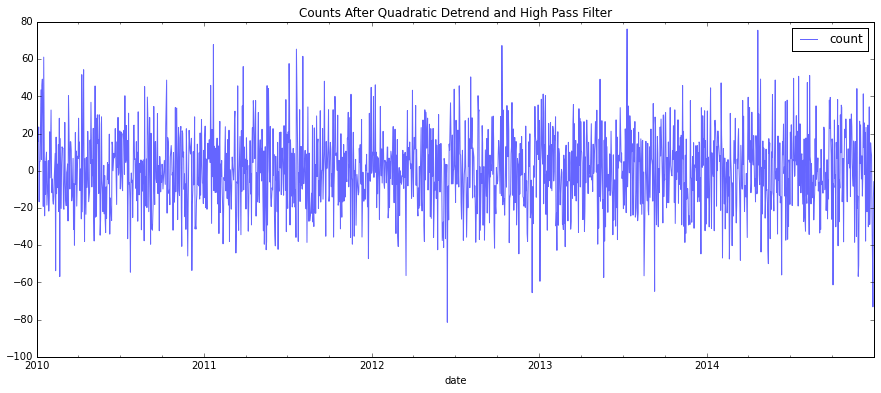

In [101]:
frq = 1 / 85.3 # from FFT output above
out = sigtools.hi_pass_filter(det_curve, frq, 1.0, 2)

dff = pd.DataFrame({'count':out}, index=df.index)
dff.plot(title="Counts After Quadratic Detrend and High Pass Filter", figsize=(15,6), alpha=0.6)

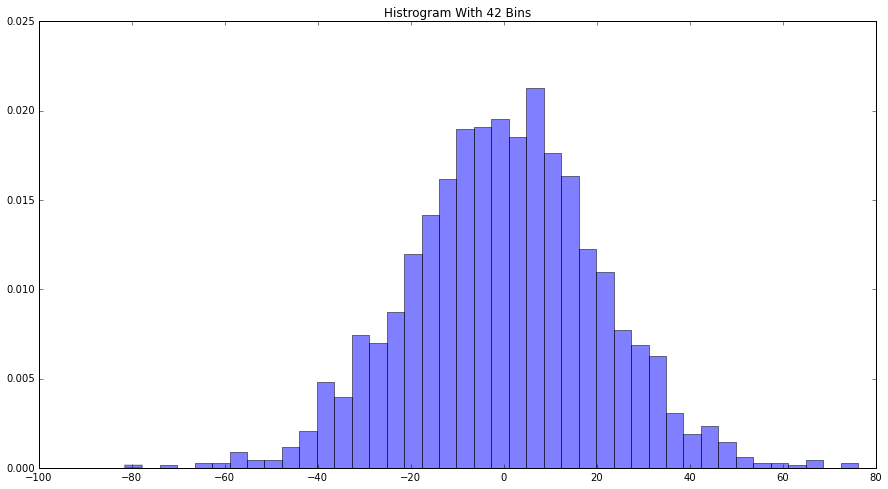

In [102]:
plt.figure(figsize=(15,8))

nbins = np.floor(np.sqrt(out.shape[0]))
y_counts, bin_x, patch = plt.hist(out, nbins, normed=True, alpha=0.5);
string = "Histrogram With %s Bins" % str(int(nbins))
plt.title(string)

Perhaps a Gausian

In [103]:
bin_x = bin_x[1:]# drop the first bin to match the array lengths

In [104]:
from scipy.optimize import curve_fit

In [105]:
def gauss(x, *p):
    A, mu, sig = p
    gau = A * np.exp(-(x-mu)**2 / 2.0 * sig**2)
    return gau

In [108]:
coeff, var_matrix = curve_fit(gauss, bin_x, y_counts, p0=[0.1, 0.0, 0.1])
print "Amplitude:%f  mean:%f   std:%f" %(coeff[0], coeff[1], coeff[2])

Amplitude:0.019967  mean:2.184505   std:0.050485


<Container object of 42 artists>

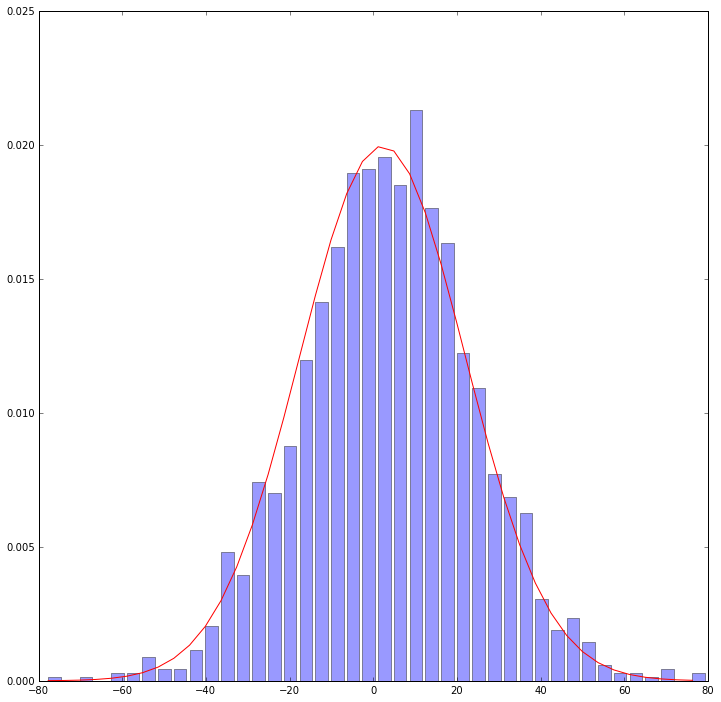

In [107]:
fit_gau = gauss(bin_x, *coeff)
plt.figure(figsize=(12, 12))

plt.plot(bin_x, fit_gau, 'r')
plt.bar(bin_x, y_counts, alpha=0.4, width=3)

# Summary Write Up

Hidden in the periodic noise is the more interesting signal. It's random from a Gaussian distribution.
